In [1]:
import pygmsh
import numpy as np


#function to rotate a point around the origin
def rotatept(xy, ang):
    x, y = xy
    xx = x * np.cos(ang) + y * np.sin(ang)
    yy = -x * np.sin(ang) + y * np.cos(ang)

    return xx, yy

## Set basic parameters

In [17]:
boxlen = 3.5
boxwidth = 1.5
swimwidth = 0.9
swimlength = 0.77

propdia = 0.4826
propthick = 20e-3
propxpos = swimlength+0.47
propypos = boxwidth/2

steerangle = np.deg2rad(20) #Change this value to change steering angle
closure = 0 #Change this value from 0 to 1 to simulate rudder fully open to fully closed

rudrad = 0.508/2
rudmidlead = 0.3
rudmidlag = 0.3
TEang = np.arctan(rudmidlag/rudrad)
closeangle = closure * (np.deg2rad(90)-TEang)

lc = 20e-3
lcfine = 4e-3

0.0


## Set points for rudder postion

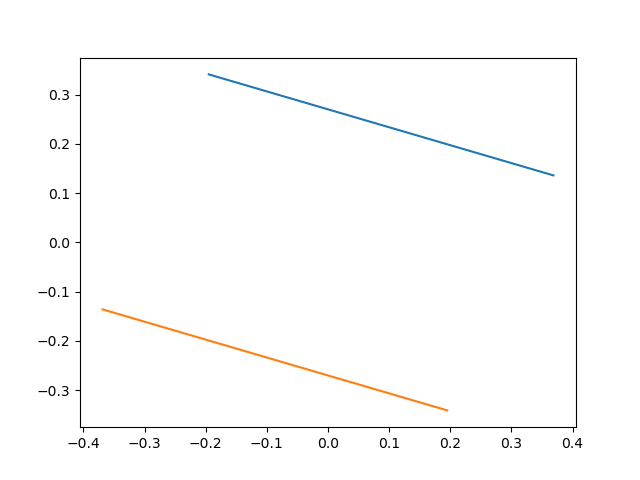

In [20]:
from matplotlib import pyplot as plt
%matplotlib widget 

fig = plt.figure()
pt10 = rotatept((-rudmidlead,rudrad),steerangle+closeangle)
pt10a = rotatept((-rudmidlead,rudrad+3e-3),steerangle+closeangle)
pt11 = rotatept((rudmidlag,rudrad),steerangle+closeangle)
pt11a = rotatept((rudmidlag,rudrad+3e-3),steerangle+closeangle)
pt12 = rotatept((-rudmidlead,-rudrad),steerangle-closeangle)
pt12a = rotatept((-rudmidlead,-rudrad-3e-3),steerangle-closeangle)
pt13 = rotatept((rudmidlag,-rudrad),steerangle-closeangle)
pt13a = rotatept((rudmidlag,-rudrad-3e-3),steerangle-closeangle)

plt.plot((pt10[0],pt11[0]),(pt10[1],pt11[1]))
plt.plot((pt12[0],pt13[0]),(pt12[1],pt13[1]))

## Generate mesh

In [19]:


with pygmsh.geo.Geometry() as geom:
    #Box
    p1 = geom.add_point([-propxpos,-propypos], lc)
    p2 = geom.add_point([boxlen-propxpos,-propypos], lc)
    p3 = geom.add_point([boxlen-propxpos,boxwidth-propypos], lc)
    p4 = geom.add_point([-propxpos,boxwidth-propypos], lc)
    p41 = geom.add_point([-propxpos,swimwidth/2], lc)
    p42 = geom.add_point([-propxpos+swimlength,0], lcfine)
    p43 = geom.add_point([-propxpos,-swimwidth/2], lc)
    
    L1 = geom.add_line(p1,p2)
    L2 = geom.add_line(p2,p3)
    L3 = geom.add_line(p3,p4)
    L4 = geom.add_line(p4,p41)
    L41 = geom.add_line(p41,p42)
    L42 = geom.add_line(p42,p43)
    L43 = geom.add_line(p43,p1)
    
    loopBox = geom.add_curve_loop([L4, L41,L42,L43,L1, L2, L3])
    
    #Prop
    p5 = geom.add_point([propthick/2,propdia/2], lcfine)
    p6 = geom.add_point([-propthick/2,propdia/2], lcfine)
    p7 = geom.add_point([-propthick/2,-propdia/2], lcfine)
    p8 = geom.add_point([propthick/2,-propdia/2], lcfine)
    
    L5 = geom.add_line(p5,p6)
    L6 = geom.add_line(p6,p7)
    L7 = geom.add_line(p7,p8)
    L8 = geom.add_line(p8,p5)
    
    loopProp = geom.add_curve_loop([L5,L6,L7,L8])
    
    #Rudder
    p10 = geom.add_point(pt10, lcfine)
    p11 = geom.add_point(pt11, lcfine)
    p12 = geom.add_point(pt12, lcfine)
    p13 = geom.add_point(pt13, lcfine)
    p10a = geom.add_point(pt10a, lcfine)
    p11a = geom.add_point(pt11a, lcfine)
    p12a = geom.add_point(pt12a, lcfine)
    p13a = geom.add_point(pt13a, lcfine)
    
    

    if closure == 1:
        L10 = geom.add_line(p10,p11)
        L11 = geom.add_line(p11,p12)
        L11c = geom.add_line(p12,p12a)
        L11a = geom.add_line(p12a,p13a)
        L12 = geom.add_line(p13a,p11a)
        L10a = geom.add_line(p11a,p10a)
        L10b = geom.add_line(p10a,p10)
        
        loopRud = loopRud1 = geom.add_curve_loop([L10,L11,L11c,L11a,L12,L10a,L10b])
        surfBox = geom.add_plane_surface(loopBox, holes=[loopProp,loopRud])
    else:    
        L10 = geom.add_line(p10,p11)
        L10a = geom.add_line(p10a,p11a)
        L10b = geom.add_line(p10,p10a)
        L10c = geom.add_line(p11,p11a)
        L11 = geom.add_line(p12,p13)
        L11a = geom.add_line(p12a,p13a)
        L11b = geom.add_line(p12,p12a)
        L11c = geom.add_line(p13,p13a)
        
        loopRud1 = geom.add_curve_loop([L10,L10c,-L10a,-L10b])
        loopRud2 = geom.add_curve_loop([L11,L11c,-L11a,-L11b])
        surfBox = geom.add_plane_surface(loopBox, holes=[loopProp,loopRud1,loopRud2])
    fluid = geom.add_physical(surfBox, label='fluid')
    swimtop = geom.add_physical(L41, label='swimtop')
    swimbot = geom.add_physical(L42, label='swimbot')
    propIn = geom.add_physical(L6, label='propIn')
    propOut = geom.add_physical(L8, label='propOut')
    rud1 = geom.add_physical(L10, label='rudtt')
    rud2 = geom.add_physical(L11, label='rudbt')
    rud3 = geom.add_physical(L10a, label='rudtb')
    rud4 = geom.add_physical(L11a, label='rudbb')
    mesh = geom.generate_mesh()
    geom.save_geometry('krudder.geo_unrolled')
    pygmsh.write("krudder.msh")

#generate_mesh(geom, )
#mesh.write("out.msh")

# ROUGH WORKING

In [9]:
from py2gmsh import (Mesh, Entity, Field)

# create Mesh class instance
my_mesh = Mesh()

# create points
p1 = Entity.Point([0., 0., 0.])
# add point to mesh
my_mesh.addEntity(p1)
#create more points
p2 = Entity.Point([1., 0., 0.])
my_mesh.addEntity(p2)
p3 = Entity.Point([1., 1., 0.])
my_mesh.addEntity(p3)
# entities can also directly be added to a mesh:
p4 = Entity.Point([0., 1., 0.], mesh=my_mesh)

# create curves
l1 = Entity.Curve([p1, p2])
l2 = Entity.Curve([p2, p3])
l3 = Entity.Curve([p3, p4])
l4 = Entity.Curve([p4, p1])
# entities can also be added in a batch
my_mesh.addEntities([l1, l2, l3, l4])

# create curveloop
ll1 = Entity.CurveLoop([l1, l2, l3, l4], mesh=my_mesh)

# create surface
s1 = Entity.PlaneSurface([ll1], mesh=my_mesh)

# create fields
f1 = Field.MathEval(mesh=my_mesh)
grading = 1.1
he = 0.005
f1.F = '(abs(y-0.5)*({grading}-1)+{he})/{grading}'.format(grading=grading,
                                                          he=he)
# create minimum field
fmin = Field.Min(mesh=my_mesh)
fmin.FieldsList = [f1]  # could add more fields in the list if necessary

# set the background field as minimum field
my_mesh.setBackgroundField(fmin)

# set max element size
my_mesh.Options.Mesh.CharacteristicLengthMax = 0.1

# adding Coherence option
my_mesh.Coherence = True

# write the geofile
my_mesh.writeGeo('my_mesh.geo')

In [6]:
import pygmsh
help(pygmsh.geo.Geometry().add_line)

Help on method add_line in module pygmsh.common.geometry:

add_line(*args, **kwargs) method of pygmsh.geo.geometry.Geometry instance



In [13]:
#from pygmsh import Geometry
from pygmsh.helpers import generate_mesh

geom = Geometry()
geom.add_point([0] * 3)

generate_mesh(geom, geo_filename='o.geo', msh_filename='o.msh')

ImportError: cannot import name 'generate_mesh' from 'pygmsh.helpers' (/home/timbo/anaconda3/lib/python3.8/site-packages/pygmsh/helpers.py)

In [ ]:
import os
os.system('gmsh krudder.geo -2')

Info    : Running '/home/timbo/anaconda3/bin/gmsh krudder.geo -2' [Gmsh 4.10.3, 1 node, max. 1 thread]
Info    : Started on Fri May 27 21:39:53 2022
Info    : Reading 'krudder.geo'...
Info    : Done reading 'krudder.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 70%] Meshing curve 8 (Line)
Info    : [ 80%] Meshing curve 41 (Line)
Info    : [ 90%] Meshing curve 42 (Line)
Info    : [100%] Meshing curve 43 (Line)
Info    : Done meshing 1D (Wall 0.0171187s, CPU 0.012355s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 3.82239s, CPU 3.76597s)
Info    : 65198 nodes 130407 elements
Info    : Writing 'krudder.msh'...
Info    : Done writing 'krudder.msh'
Info    :

0

[-0.24824355652982144, 0.14997045256124744]
[0.5658203230275509, 0.6199704525612475]
[0.005756443470178558, -0.2899704525612474]
[0.819820323027551, 0.1800295474387526]
[-0.24824355652982144, 0.15297045256124744]
[0.5658203230275509, 0.6229704525612475]
[0.005756443470178558, -0.29297045256124743]
[0.819820323027551, 0.1770295474387526]


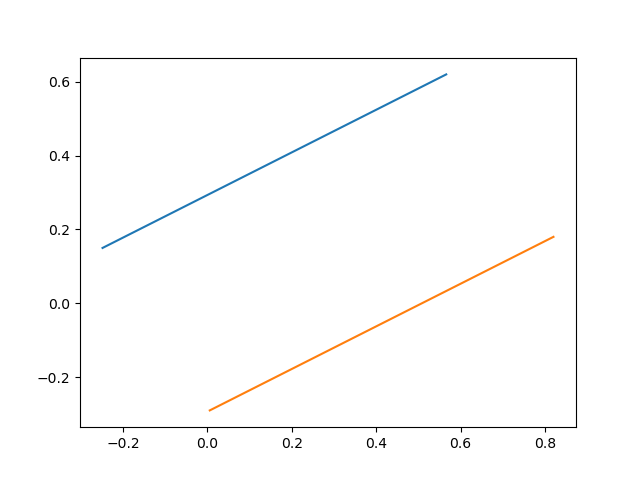

In [11]:
from matplotlib import pyplot as plt
%matplotlib widget 

fig = plt.figure()
pt10 = [-(np.sin(rudmidLEang+steerangle)*rudmidLEdist), (np.cos(rudmidLEang+steerangle)*rudmidLEdist)]
pt10a = [-(np.sin(rudmidLEang+steerangle)*rudmidLEdist), (np.cos(rudmidLEang+steerangle)*rudmidLEdist)+3e-3]
pt11 = [(np.sin(rudmidTEang-steerangle)*rudmidTEdist), (np.cos(rudmidTEang-steerangle)*rudmidTEdist)]
pt11a = [(np.sin(rudmidTEang-steerangle)*rudmidTEdist), (np.cos(rudmidTEang-steerangle)*rudmidTEdist)+3e-3]
pt12 = [-(np.sin(rudmidLEang-steerangle)*rudmidLEdist), -(np.cos(rudmidLEang-steerangle)*rudmidLEdist)]
pt12a = [-(np.sin(rudmidLEang-steerangle)*rudmidLEdist), -(np.cos(rudmidLEang-steerangle)*rudmidLEdist)-3e-3]
pt13 = [(np.sin(rudmidTEang+steerangle)*rudmidTEdist), -(np.cos(rudmidTEang+steerangle)*rudmidTEdist)]
pt13a = [(np.sin(rudmidTEang+steerangle)*rudmidTEdist), -(np.cos(rudmidTEang+steerangle)*rudmidTEdist)-3e-3]
    
print(pt10)
print(pt11)
print(pt12)
print(pt13)
print(pt10a)
print(pt11a)
print(pt12a)
print(pt13a)
plt.plot((pt10[0],pt11[0]),(pt10[1],pt11[1]))
plt.plot((pt12[0],pt13[0]),(pt12[1],pt13[1]))


In [4]:
help(pygmsh)

Help on package pygmsh:

NAME
    pygmsh

PACKAGE CONTENTS
    _cli
    _optimize
    common (package)
    geo (package)
    helpers
    occ (package)

FUNCTIONS
    optimize(mesh, method='', verbose=False)
    
    orient_lines(lines)
        Given a sequence of unordered and unoriented lines defining a closed polygon,
        returns a reordered list of reoriented lines of that polygon.
        
        :param lines: a sequence of lines defining a closed polygon
    
    rotation_matrix(u, theta)
        Return matrix that implements the rotation around the vector :math:`u`
        by the angle :math:`\theta`, cf.
        https://en.wikipedia.org/wiki/Rotation_matrix#Rotation_matrix_from_axis_and_angle.
        
        :param u: rotation vector
        :param theta: rotation angle
    
    write(filename: str)

DATA
    __all__ = ['geo', 'occ', 'rotation_matrix', 'orient_lines', 'write', '...

FILE
    /home/timbo/anaconda3/lib/python3.8/site-packages/pygmsh/__init__.py


